In [1]:
#using DifferentialEquations
#using ADCME
using Plots

In [2]:
function f_hi(a, T, R)
        v1 = (a[:,2] + a[:,3] * T + a[:,4] * T^2 + a[:,5] * T^3 + a[:,6] * T^4) * R
        v2 = (a[:,2] + a[:,3] * T / 2 + a[:,4] * T^2 /3 + a[:,5] * T^3 /4 + a[:,6] * T^4 /5 + a[:,7] / T) * R * T
        v3 = (a[:,2] * log(T) + a[:,3] * T + a[:,4] * T^2 /2 + a[:,5] * T^3 /3 + a[:,6] * T^4 / 4 + a[:,8]) * R
    return [v1 v2 v3]
end
 
function f_lo(a, T, R)
    v1 = (a[:,9] + a[:,10] * T + a[:,11] * T^2 + a[:,12] * T^3 + a[:,13] * T^4) * R
    v2 = (a[:,9] + a[:,10] * T / 2 + a[:,11] * T^2 /3 + a[:,12] * T^3 /4 + a[:,13] * T^4 /5 + a[:,14]/T) * R * T
    v3 = (a[:,9] * log(T) + a[:,10] * T + a[:,11] * T^2 /2 + a[:,12] * T^3 /3 + a[:,13] * T^4 / 4 + a[:,15]) * R
    return [v1 v2 v3]
end 

function compute_falloff(T, pr, a)
    fcent = (1 - a[1]) * exp(-T/a[2]) + a[1] * exp(-T/a[3]) + exp(-a[4]/T)
    c = -0.4 - 0.67 * log(10, fcent)
    n = 0.75 - 1.27 * log(10, fcent)
    f1 = (log(10, pr) + c) / (n - 0.14 *(log(10, pr) + c))
    return  10 ^ (log(10, fcent) / (1 + f1 ^ 2))
end

compute_falloff (generic function with 1 method)

In [3]:
using PyCall
#### Read data
py"""
import numpy as np
"""

In [4]:
V = 1  # Volume
m = (py"np.load"("data/density.npy"))[1] # Total mass
tbd = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/tbd.npy") .+ 1
tbd = Int.(tbd)
falofr = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/falofr.npy") .+ 1
falofr = Int.(falofr)
elmr = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/elmr.npy") .+ 1
elmr = Int.(elmr)
NASA_coeffs = py"np.load"("data/NASA_coeffs.npy")
W = py"np.load"("data/molecular_weights.npy") # Molar weight
ν1 = py"np.load"("data/reactants_stoich_coeffs.npy") # Forward molar stoichiometric coefficients
ν2 = py"np.load"("data/product_stoich_coeffs.npy") # Backward model stoichiometric coefficients
reversible = py"np.load"("data/reversible.npy")
N = size(ν1)[1]  # Number of Species
M = size(ν1)[2]  # Number of Reactions
ν1_order = zeros(N,M)
ν = ν2 - ν1  
pa = 100000 # 1 bar
R = 8314.4621 # Gas constant in kmol
### Constants: Combustion Chamber Level
min_dot = 0 # Rate at which mass enters the chamber
mout_dot = 0 # Rate at which mass leaves the chamber
Yin = ones(N) # Mass fraction of species entering the chamber
Yout = ones(N) # Mass fraction of species leaving the chamber
Qdot = 0 # Heating source
m_dot = min_dot - mout_dot
hin = 1 # Enthalpy of input
### Unknowns
Tt_cant = py"np.load"("data/temperature.npy")
T = Tt_cant[1] # Temperature
Y = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/ini_mass_fraction.npy") # Mass fractions
### Quantities that depend on the Unknowns
order = py"np.load"("data/reaction_orders.npy")
Af = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor.npy") # preexponential constant Afj
β = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent.npy") # Temperature exponent
E = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy.npy") # Activation energy for the reactions in kJ

order_t = py"np.load"("data/reaction_orders_t.npy")
efficiency_t = py"np.load"("data/efficiency_t.npy")
Af_t = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_t.npy") # preexponential constant Afj
β_t = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_t.npy") # Temperature exponent
E_t = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_t.npy") # Activation energy for the reactions in kJ

order_f = py"np.load"("data/reaction_orders_f.npy")
troefall = py"np.load"("data/troefall.npy") .+ 1
troefall_coeff = py"np.load"("data/troefall_coeff.npy")
efficiency_f = py"np.load"("data/efficiency_f.npy")
Af_hi = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_hi.npy") # preexponential constant Afj
β_hi = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_hi.npy") # Temperature exponent
E_hi = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_hi.npy") 

Af_lo = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/pre_exponential_factor_lo.npy") # preexponential constant Afj
β_lo = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/temperature_exponent_lo.npy") # Temperature exponent
E_lo = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/activation_energy_lo.npy") 

ν1_order[:,elmr] = order
ν1_order[:,tbd] = order_t
ν1_order[:,falofr] = order_f


6×0 Array{Float64,2}

In [5]:
ρ = m / V # density
X = ρ * Y ./ W # Concentration
Q = ones(M) # Individual progress rates
# cpHS = compute_cpHS(NASA_coeffs, R, T)
# cp = cpHS[:,1]
# h = cpHS[:,2]
# s = cpHS[:,3]
islarge = NASA_coeffs[:,1] .< T * ones(N)
fhi = f_hi(NASA_coeffs, T, R)
flo = f_lo(NASA_coeffs, T, R)
cp = islarge .* fhi[:,1] + (1 .- islarge) .* flo[:,1]
h = islarge .* fhi[:,2] + (1 .- islarge) .* flo[:,2]
s = islarge .* fhi[:,3] + (1 .- islarge) .* flo[:,3]
cvk = cp .- R
ΔS = ν' * s  # Entropy change for reaction j
ΔH = ν' * h # Entahlpy change for reaction j
####
M_t = efficiency_t' * X
Kf_t = Af_t .* (T .^ β_t) .* exp.(-E_t ./ (R * T)) .* M_t
Kr_t = Kf_t ./ (((pa/(R * T)) .^ sum(ν[:,tbd], dims=1)' .* exp.(ΔS[tbd] ./ R - ΔH[tbd] ./ (R * T))))
Qtbd = Kf_t .* prod(X .^ order_t, dims=1)' .- Kr_t .* prod(X .^ ν2[:,tbd], dims=1)' .* reversible[tbd]
####
M_f = efficiency_f' * X
Kf_lo = Af_lo .* (T .^ β_lo) .* exp.(-E_lo ./ (R * T)) .* M_f
Kf_hi = Af_hi .* (T .^ β_hi) .* exp.(-E_hi ./ (R * T)) 
Pr = Kf_lo ./ Kf_hi
Fac = ones(size(falofr)[1])
Fac[troefall] = [compute_falloff(T, Pr[s], troefall_coeff[:,i]) for (i,s) in enumerate(troefall)]
Kf_f = Kf_lo ./ (1 .+ (Kf_lo ./ Kf_hi)) .* Fac
Kr_f = Kf_f ./ (((pa/(R * T)) .^ sum(ν[:,falofr], dims=1)' .* exp.(ΔS[falofr] ./ R - ΔH[falofr] ./ (R * T))))
Qfalofr = Kf_f .* prod(X .^ order_f, dims=1)' .- Kr_f .* prod(X .^ ν2[:,falofr], dims=1)' .* reversible[falofr]
####
Kf = Af .* (T .^ β) .* exp.(-E ./ (R * T))
Kr = Kf ./ (((pa/(R * T)) .^ sum(ν[:,elmr], dims=1)' .* exp.(ΔS[elmr] ./ R - ΔH[elmr] ./ (R * T))))
Qelmr = Kf .* prod(X .^ order, dims=1)' .- Kr .* prod(X .^ ν2[:,elmr], dims=1)' .* reversible[elmr]
##### Computing ω_dot 
cv = sum(cvk ./ W .* Y) # Mass heat capacities
u = h ./ W - R ./ W .* T   # Internal energy for species
p = sum(X) * R * T # pressure
Q = [Qtbd' Qfalofr' Qelmr']
ν_new = [ν[:,tbd] ν[:,falofr] ν[:,elmr]]
ω_dot = W .* sum(ν_new .* Q, dims=2)
###### Species Conservation
mgen_dot = V .* ω_dot
Y_dot = (1 / m) .* (min_dot .* (Yin .- Y) - mout_dot .* Y .+ mgen_dot) 
###### Energy Conservation
T_dot = 1 / (m * cv) * (-Qdot + min_dot * (hin - sum(u .* Yin)) - p * V / m * mout_dot - sum(mgen_dot .* u))

29251.078856934666

In [6]:
function q(t)
    t0 = 1e-5
    r = 1e-6
    c = 1e12
    return c * exp(-(t-t0)^2 / r^2)
end

q (generic function with 1 method)

In [7]:
function f(TY, t)
    T = TY[1]
    Y = TY[2:end]
    ρ = m / V # density
    X = ρ * Y ./ W # Concentration
    Q = ones(M) # Individual progress rates
    islarge = NASA_coeffs[:,1] .< T * ones(N)
    fhi = f_hi(NASA_coeffs, T, R)
    flo = f_lo(NASA_coeffs, T, R)
    cp = islarge .* fhi[:,1] + (1 .- islarge) .* flo[:,1]
    h = islarge .* fhi[:,2] + (1 .- islarge) .* flo[:,2]
    s = islarge .* fhi[:,3] + (1 .- islarge) .* flo[:,3]
    cvk = cp .- R
    ΔS = ν' * s  # Entropy change for reaction j
    ΔH = ν' * h # Entahlpy change for reaction j
    ####
    M_t = efficiency_t' * X
    Kf_t = Af_t .* (T .^ β_t) .* exp.(-E_t ./ (R * T)) .* M_t
    Kr_t = Kf_t ./ (((pa/(R * T)) .^ sum(ν[:,tbd], dims=1)' .* exp.(ΔS[tbd] ./ R - ΔH[tbd] ./ (R * T))))
    Qtbd = Kf_t .* prod(X .^ order_t, dims=1)' .- Kr_t .* prod(X .^ ν2[:,tbd], dims=1)' .* reversible[tbd]
    ####
    M_f = efficiency_f' * X
    Kf_lo = Af_lo .* (T .^ β_lo) .* exp.(-E_lo ./ (R * T)) .* M_f
    Kf_hi = Af_hi .* (T .^ β_hi) .* exp.(-E_hi ./ (R * T)) 
    Pr = Kf_lo ./ Kf_hi
    Fac = ones(size(falofr)[1])
    Fac[troefall] = [compute_falloff(T, Pr[s], troefall_coeff[:,i]) for (i,s) in enumerate(troefall)]
    Kf_f = Kf_lo ./ (1 .+ (Kf_lo ./ Kf_hi)) .* Fac
    Kr_f = Kf_f ./ (((pa/(R * T)) .^ sum(ν[:,falofr], dims=1)' .* exp.(ΔS[falofr] ./ R - ΔH[falofr] ./ (R * T))))
    Qfalofr = Kf_f .* prod(X .^ order_f, dims=1)' .- Kr_f .* prod(X .^ ν2[:,falofr], dims=1)' .* reversible[falofr]
    ####
    Kf = Af .* (T .^ β) .* exp.(-E ./ (R * T))
    Kr = Kf ./ (((pa/(R * T)) .^ sum(ν[:,elmr], dims=1)' .* exp.(ΔS[elmr] ./ R - ΔH[elmr] ./ (R * T))))
    Qelmr = Kf .* prod(X .^ order, dims=1)' .- Kr .* prod(X .^ ν2[:,elmr], dims=1)' .* reversible[elmr]
    ##### Computing ω_dot 
    cv = sum(cvk ./ W .* Y) # Mass heat capacities
    u = h ./ W - R ./ W .* T   # Internal energy for species
    p = sum(X) * R * T # pressure
    Q = [Qtbd' Qfalofr' Qelmr']
    ν_new = [ν[:,tbd] ν[:,falofr] ν[:,elmr]]
    ω_dot = W .* sum(ν_new .* Q, dims=2)
    ###### Species Conservation
    mgen_dot = V .* ω_dot
    Y_dot = (1 / m) .* (min_dot .* (Yin .- Y) - mout_dot .* Y .+ mgen_dot) 
    ###### Energy Conservation
    T_dot = 1 / (m * cv) * (q(t) + min_dot * (hin - sum(u .* Yin)) - p * V / m * mout_dot - sum(mgen_dot .* u))
    return [T_dot; Y_dot]
end

f (generic function with 1 method)

In [8]:
timestep

LoadError: UndefVarError: timestep not defined

In [9]:
## RK4
#dt = 4e-9
timestep = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/timestep.npy")
n_t = size(timestep)[1]
#n_t = 2000
T = Tt_cant[1] # Temperature
Y = py"np.load"("/home/darve/adncat/yizhou/PSAAP3/Tests/data/ini_mass_fraction.npy") # Mass fractions
TY = [T;Y]
TYt = zeros(N+1, n_t)
Tt = zeros(n_t)
Pt = zeros(n_t)
Yt = zeros(N,n_t)
Y0 = copy(Y)
Yt[:,1] .= Y
Tt[1] = T
X = ρ * Y ./ W
Pt[1] = sum(X) * R * T
for i = 1:n_t - 1
    dt = timestep[i+1] - timestep[i]
    k1 = f(TY, timestep[i])
    k2 = f(TY + 0.5 * dt * k1, timestep[i] + 0.5 * dt)
    k3 = f(TY + 0.5 * dt * k2, timestep[i] + 0.5 * dt)
    k4 = f(TY + dt * k3, timestep[i] + dt)
    TY += 1/6 * dt * (k1 + 2 * k2 + 2 * k3 + k4)
    #TY += dt * f(TY,timestep[i])
    Tt[i+1] = TY[1]
    println(TY[1])
    println(i)
    Y = TY[2:end]
    Yt[:,i+1] = Y
    X = ρ * Y ./ W
    TYt[:,i+1] = TY
    Pt[i+1] = sum(X) * R * TY[1]
end



500.0000093603456
1
500.00001872069276
2
500.00003276121726
3
500.00005148192344
4
500.0000748828172
5
500.000102963906
6
500.00013572519856
7
500.0001731667052
8
500.0002152884378
9
500.00026209040954
10
500.0003135726352
11
500.00036973513096
12
500.0004305779145
13
500.000496101005
14
500.0005663044231
15
500.00064118819085
16
500.00072075233186
17
500.0008049968712
18
500.00089392183537
19
500.0009875272524
20
500.0010858131517
21
500.00118877956425
22
500.00129642652246
23
500.0014087540602
24
500.0015257622129
25
500.00164745101733
26
500.00177382051186
27
500.00190487073627
28
500.0020406017318
29
500.00218101354113
30
500.00232610620856
31
500.00247587977975
32
500.0026303343019
33
500.0027894698236
34
500.0029532863949
35
500.0031217840675
36
500.00329496289436
37
500.00347282293006
38
500.00365536423055
39
500.00384258685335
40
500.0040344908574
41
500.00423107630314
42
500.00443234325246
43
500.0046382917688
44
500.00484892191696
45
500.0050642337632
46
500.00528422737545
47

In [51]:
#X = [i * 4e-9 for i = 1:2000]
Yt_cant = py"np.load"("data/mass_fraction.npy")
plot(timestep, Yt')
#plot!(X,  Yt_cant')
xlabel!("Time")
ylabel!("Mass Fractions")
savefig("Mass_fraction.pdf")

In [183]:
plot(timestep, Yt')
xlabel!("Time")
ylabel!("Mass Fractions")
savefig("Mass_fraction.pdf")

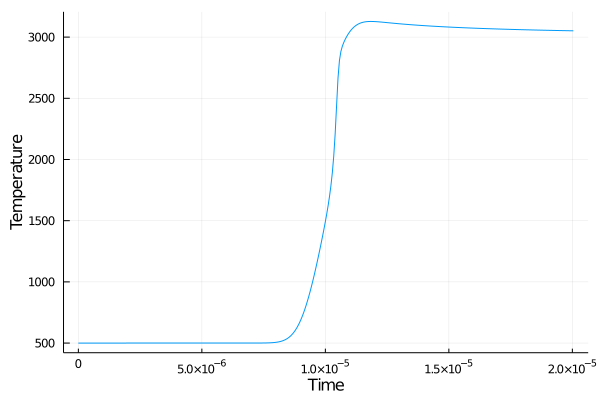

In [12]:
#X = [i * 4e-9 for i = 1:2000]
Tt_cant = py"np.load"("data/temperature.npy")
plot(timestep, Tt, legend = false, title="")
#plot!(timestep[2:end], Tt_cant)
xlabel!("Time")
ylabel!("Temperature")
#savefig("Temperature.pdf")

In [ ]:
X = [i * 4e-9 for i = 1:2000]
Pt_cant = py"np.load"("data/pressure.npy")
plot(timestep, Pt)
plot!(X, Pt_cant)
xlabel!("Time")
ylabel!("Pressure")

In [ ]:
plot(X, Tt)
Tt_cant = py"np.load"("data/temperature.npy")
plot(X, [Tt Tt_cant], label = ["Julia" "Cantera"])
xlabel!("Time")
ylabel!("Temperature")
#savefig("Temperautre.pdf")

In [29]:
Tt

2001-element Array{Float64,1}:
  500.0
  500.00029251171594
  500.00058502535046
  500.0008775409036
  500.0011700583754
  500.00146257776584
  500.00175509907496
  500.00204762230277
  500.00234014744933
  500.00263267451464
  500.00292520349876
  500.00321773440163
  500.00351026722336
    ⋮
 3051.9681894646483
 3051.930540591628
 3051.8929527967844
 3051.855425937356
 3051.8179598710167
 3051.780554455875
 3051.7432095504723
 3051.70592501378
 3051.6687007052
 3051.6315364845614
 3051.594432212119
 3051.557387748553

In [ ]:
dt = 1e-12
for i = 1:n_t
    k1 = f(TY)
    k2 = f(TY + 0.5 * dt * k1)
    k3 = f(TY + 0.5 * dt * k2)
    k4 = f(TY + dt * k3)
    TY += 1/6 * dt * (k1 + 2 * k2 + 2 * k3 + k4)
    #TY += dt * f(TY)
    Tt[i] = TY[1]
    print(TY[1])
    println(i)
    Y = TY[2:end]
    Yt[:,i] = Y
    X = ρ * Y ./ W
    p = sum(X) * R * TY[1]
    TYt[:,i] = TY
    Pt[i] = p
end

In [ ]:
function forward!(dty, ty, p, t)
    T = ty[1]
    Y = ty[2:end]
    ρ = m / V # density
    X = ρ * Y ./ W # Concentration
    Q = ones(M) # Individual progress rates
    # cpHS = compute_cpHS(NASA_coeffs, R, T)
    # cp = cpHS[:,1]
    # h = cpHS[:,2]
    # s = cpHS[:,3]
    #islarge = NASA_coeffs[:,1] .< T * ones(N)
    fhi = f_hi(NASA_coeffs, T, R)
    #flo = f_lo(NASA_coeffs, T, R)
    
#     cp = islarge .* fhi[:,1] + (1 .- islarge) .* flo[:,1]
#     h = islarge .* fhi[:,2] + (1 .- islarge) .* flo[:,2]
#     s = islarge .* fhi[:,3] + (1 .- islarge) .* flo[:,3]
    cp = fhi[:,1] 
    h = fhi[:,2] 
    s = fhi[:,3] 
    cvk = cp .- R
    ΔS = ν' * s  # Entropy change for reaction j
    ΔH = ν' * h # Entahlpy change for reaction j
    ####
    M_t = efficiency_t' * X
    Kf_t = Af_t .* (T .^ β_t) .* exp.(-E_t ./ (R * T)) .* M_t
    Kr_t = Kf_t ./ (((pa/(R * T)) .^ sum(ν[:,tbd], dims=1)' .* exp.(ΔS[tbd] ./ R - ΔH[tbd] ./ (R * T))))
    Qtbd = Kf_t .* prod(X .^ order_t, dims=1)' .- Kr_t .* prod(X .^ ν2[:,tbd], dims=1)' .* reversible[tbd]
    ####
    M_f = efficiency_f' * X
    Kf_lo = Af_lo .* (T .^ β_lo) .* exp.(-E_lo ./ (R * T)) .* M_f
    Kf_hi = Af_hi .* (T .^ β_hi) .* exp.(-E_hi ./ (R * T)) 
    Pr = Kf_lo ./ Kf_hi
    Fac = ones(size(falofr)[1])
    Fac[troefall] = [compute_falloff(T, Pr[s], troefall_coeff[:,i]) for (i,s) in enumerate(troefall)]
    Kf_f = Kf_lo ./ (1 .+ (Kf_lo ./ Kf_hi)) .* Fac
    Kr_f = Kf_f ./ (((pa/(R * T)) .^ sum(ν[:,falofr], dims=1)' .* exp.(ΔS[falofr] ./ R - ΔH[falofr] ./ (R * T))))
    Qfalofr = Kf_f .* prod(X .^ order_f, dims=1)' .- Kr_f .* prod(X .^ ν2[:,falofr], dims=1)' .* reversible[falofr]
    ####
    Kf = Af .* (T .^ β) .* exp.(-E ./ (R * T))
    Kr = Kf ./ (((pa/(R * T)) .^ sum(ν[:,elmr], dims=1)' .* exp.(ΔS[elmr] ./ R - ΔH[elmr] ./ (R * T))))
    Qelmr = Kf .* prod(X .^ order, dims=1)' .- Kr .* prod(X .^ ν2[:,elmr], dims=1)' .* reversible[elmr]
    ##### Computing ω_dot 
    cv = sum(cvk ./ W .* Y) # Mass heat capacities
    u = h ./ W - R ./ W .* T   # Internal energy for species
    p = sum(X) * R * T # pressure
    Q = [Qtbd' Qfalofr' Qelmr']
    ν_new = [ν[:,tbd] ν[:,falofr] ν[:,elmr]]
    ω_dot = W .* sum(ν_new .* Q, dims=2)
    ###### Species Conservation
    mgen_dot = V .* ω_dot
    dty[2:end] = (1 / m) .* (min_dot .* (Yin .- Y) - mout_dot .* Y .+ mgen_dot) 
    ###### Energy Conservation
    dty[1] = 1 / (m * cv) * (-Qdot + min_dot * (hin - sum(u .* Yin)) - p * V / m * mout_dot - sum(mgen_dot .* u))
end

In [ ]:
TY = [T;Y]
u0 = TY
tspan = (0.0,0.001)
prob = ODEProblem(forward!,u0,tspan)
sol = DifferentialEquations.solve(prob)

In [ ]:
using ModelingToolkit
de = modelingtoolkitize(prob)

In [ ]:
function f_hi(a, T, R)
        v1 = (a[:,2] + a[:,3] * T + a[:,4] * T^2 + a[:,5] * T^3 + a[:,6] * T^4) * R
        v2 = (a[:,2] + a[:,3] * T / 2 + a[:,4] * T^2 /3 + a[:,5] * T^3 /4 + a[:,6] * T^4 /5 + a[:,7]/T) * R * T
        v3 = (a[:,2] * log(T) + a[:,3] * T + a[:,4] * T^2 /2 + a[:,5] * T^3 /3 + a[:,6] * T^4 / 4 + a[:,8]) * R
    return [v1 v2 v3]
end
 
function f_lo(a, T, R)
    v1 = (a[:,9] + a[:,10] * T + a[:,11] * T^2 + a[:,12] * T^3 + a[:,13] * T^4) * R
    v2 = (a[:,9] + a[:,10] * T / 2 + a[:,11] * T^2 /3 + a[:,12] * T^3 /4 + a[:,13] * T^4 /5 + a[:,14]/T) * R * T
    v3 = (a[:,9] * log(T) + a[:,10] * T + a[:,11] * T^2 /2 + a[:,12] * T^3 /3 + a[:,13] * T^4 / 4 + a[:,15]) * R
    return [v1 v2 v3]
end 

In [ ]:
islarge = NASA_coeffs[:,1] .< T * ones(N)
fhi = f_hi(NASA_coeffs, T, R)
flo = f_lo(NASA_coeffs, T, R)
cp = islarge .* fhi[:,1] + (1 .- islarge) .* flo[:,1]
h = islarge .* fhi[:,2] + (1 .- islarge) .* flo[:,2]
s = islarge .* fhi[:,3] + (1 .- islarge) .* flo[:,3]

In [ ]:
Pt

In [ ]:
tf.isgreat(T, NASA_coeffs[:,1])

In [ ]:
tbd

In [ ]:
using DifferentialEquations

In [ ]:
log.(Af)

In [ ]:
log.(E)

In [ ]:
exp(20)

In [ ]:
Af

In [ ]:
E

In [ ]:
exp(17)

In [ ]:
exp(17.9616)

In [50]:
argmax(Tt)

19987

In [52]:
timestep[argmax(Tt)] #500K

0.001997300909999999

In [55]:
timestep[argmax(Tt_cant)]  #500K

0.0019967013599999995

In [77]:
timestep[argmax(Tt)] #800K

0.000107142841

In [78]:
timestep[argmax(Tt_cant)] #800K

0.000107128203

In [103]:
timestep[argmax(Tt)] # 700K

0.000208825266

In [104]:
timestep[argmax(Tt_cant)] #700K

0.00020880482999999998

In [119]:
ignition_1000 = timestep[argmax(Tt)] #1000K

3.8224395999999995e-5

In [120]:
ignition_1000_cant = timestep[argmax(Tt_cant)] #1000K

3.821565299999999e-5

In [130]:
ignition_1200 = timestep[argmax(Tt)] #1000K

1.6014970000000003e-5

In [131]:
ignition_1200_cant = timestep[argmax(Tt_cant)] #1000K

1.6009311000000003e-5

In [139]:
ignition_1500 = timestep[argmax(Tt)] #1500K

5.328479999999997e-6

In [140]:
ignition_1500_cant = timestep[argmax(Tt_cant)] #1500K

5.3252159999999965e-6

In [149]:
ignition_1800 = timestep[argmax(Tt)] #1500K

2.2503810000000006e-6

In [150]:
ignition_1800_cant = timestep[argmax(Tt_cant)] #1500K

2.2482600000000007e-6

In [165]:
ignition_600 = timestep[argmax(Tt)] #1500K

0.0005138737109999997

In [166]:
ignition_600_cant = timestep[argmax(Tt_cant)] #1500K

0.0005138416529999998

In [185]:
ignition_500 = timestep[argmax(Tt)] #1500K

0.001996962002999999

In [186]:
ignition_500_cant = timestep[argmax(Tt_cant)] #1500K

0.001996898805999999

In [195]:
Initial_Temp = [500, 600, 700, 800, 1000, 1200, 1500, 1800]
Ignition_Delay = [ignition_500, 0.0005138737109999997, 0.000208825266, 0.000107142841, ignition_1000, ignition_1200, ignition_1500, ignition_1800]

8-element Array{Float64,1}:
 0.001996962002999999
 0.0005138737109999997
 0.000208825266
 0.000107142841
 3.8224395999999995e-5
 1.6014970000000003e-5
 5.328479999999997e-6
 2.2503810000000006e-6

In [196]:
Ignition_Delay_Cant = [ignition_500_cant, 0.000513841652999, 0.00020880482999999998, 0.000107128203, ignition_1000_cant, ignition_1200_cant, ignition_1500_cant, ignition_1800_cant]

8-element Array{Float64,1}:
 0.001996898805999999
 0.000513841652999
 0.00020880482999999998
 0.000107128203
 3.821565299999999e-5
 1.6009311000000003e-5
 5.3252159999999965e-6
 2.2482600000000007e-6

In [208]:
plot(1000 ./ Initial_Temp, Ignition_Delay, seriestype = :scatter, label = "Julia", yaxis=:log)
plot!(1000 ./ Initial_Temp, Ignition_Delay, label = "Julia")
plot!(1000 ./ Initial_Temp, Ignition_Delay_Cant, label = "Cantera")
ylabel!("Ignition Delay Time")
xlabel!("1000 / Temperature")
savefig("Ignition_Delay.pdf")

In [ ]:
ignition_500